# TFG: Notebook 2
Exploring images containing text
---

In this notebook we explore Vizwiz datasets and we answer different questions

In [176]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy  as np
import cv2
import random
import json
import pprint
from collections import Counter

In [177]:
source = '/media/arnau/SSD/VizWiz/data/captioning/train/'
plts_dir = '/media/arnau/SSD/VizWiz/plots/'
direc = '../data/'
file = "vizwiz_skill_typ_train.csv"
data = pd.read_csv(direc + file)

## Data cleaning

Here we prepare the dataset aocrdingly to our needs.

In [178]:
cleaned_data = data.dropna(axis='columns')
display(cleaned_data.head())
print(f"Dataset size: {cleaned_data.shape}")

,IMG,QSN,TXT,OBJ,COL,CNT,OTH
0,VizWiz_train_00000000.jpg,What's the name of this product?,4,3,0,0,0
1,VizWiz_train_00000001.jpg,Can you tell me what is in this can please?,2,5,1,1,0
2,VizWiz_train_00000002.jpg,Is this enchilada sauce or is this tomatoes? ...,4,3,1,0,0
3,VizWiz_train_00000003.jpg,What is the captcha on this screenshot?,4,2,1,1,0
4,VizWiz_train_00000004.jpg,What is this item?,3,5,1,0,0


Dataset size: (14239, 7)


In [179]:
interest_col = ["IMG", "QSN", "TXT"]
interest_data = cleaned_data[interest_col]

### Confidence TXT level samples

Checking what every confidence txt level looks like (ranging from 1 to 5). This will allow us to determine which confidence txt level has the highest number of images containing text.

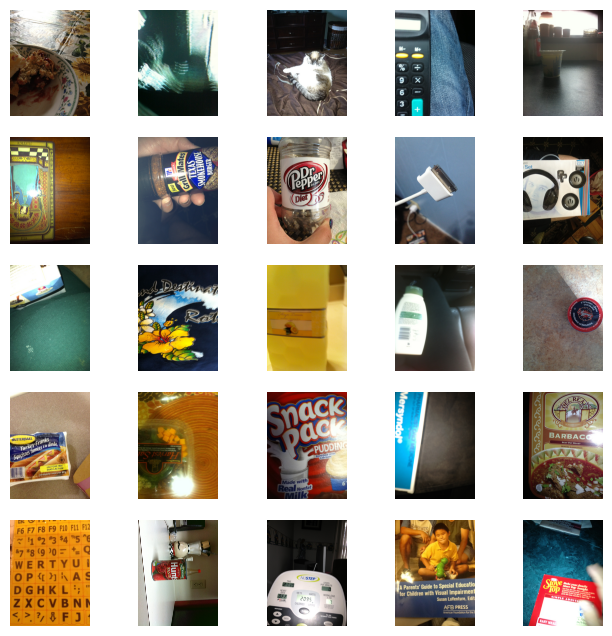

In [180]:
t_imgs = []
seed = 4

for cdf_lvl in range(1, 6):
    cdf = interest_data[interest_data["TXT"] == cdf_lvl]
    random_cdf = cdf.sample(n=5, random_state=seed)
    list_random_cdf_imgs = random_cdf["IMG"].to_list()
    t_imgs.append(list_random_cdf_imgs)
    
all_imgs = [item for sublist in t_imgs for item in sublist]

nrow, ncol = 5, 5
_, axs = plt.subplots(nrow, ncol, figsize=(8, 8))
axs = axs.flatten()
for img, ax in zip(all_imgs, axs):
    img = cv2.imread(source + img)
    imgc = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(imgc)
    ax.axis('off')

plt.show()

Once observed the different confidence txt levels, we choose the images in the dataset that have **more than 3 votes**. This level of confidence has a fairly good amount of images containing text

In [181]:
df_w_3vts = interest_data[interest_data["TXT"] >= 3]
imgs_w_txt = df_w_3vts["IMG"].to_list()
n_imgs_w_txt = df_w_3vts.shape[0]

## Assessing image quality issues

Here we will inspect how many images in the dataset contain text and are blurred.

- When it comes to blurriness, we can detect it using 2 different approaches:
    1. Detecting blurriness at a core image level.
    2. Use an alredy existing dataset that asseses this issue.

In this notebook we'll focus on the second approach.

To do so, we will work with 2 datasets:
1. The previous dataset that we used above
2. A dataset that asseses image quality issues

In dataset 2, apart from giving us which images are blurred we also get other flaws that the image could have.

Framing : FRM --- Blurried : BLR --- Dark : DRK --- Bright : BRT ---
Obstructed : OBS --- Other : OTH --- NoFlaws : NON --- Rotated : ROT


### Loading data

In [182]:
train_json_qlty = '../data/'

with open(train_json_qlty + "final.json", encoding='UTF-8') as json_file:
    data = json.load(json_file)
    data = data["train"]
    # {img_name : {info_img ...}}
    
    
data_size = len(data)
print(f"Dataset size: {data_size}")

Dataset size: 20000


In [183]:
# Sample a data item
key = list(data.keys())[0]
value = list(data.values())[0]
print(f"{key}\n")
pprint.pprint(value)

VizWiz_train_00000000.jpg

{'answerable': 1.0,
 'flaws': [True, False, False, False, False, False, False, False],
 'question': "What's the name of this product?",
 'recognizable': 1.0}


In [184]:
list_imgs_dts1 = interest_data["IMG"].to_list()
list_imgs_dts2 = list(data.keys())

print(f"Number of imgs: \n\t dataset1: {len(list_imgs_dts1)} \n\t dataset2: {len(list_imgs_dts2)}")

Number of imgs: 
	 dataset1: 14239 
	 dataset2: 20000


We want to check which images are common in both datasets

In [185]:
# From the 1st dataset, array containing all images with text
arr_imgs_w_txt = np.array(imgs_w_txt, dtype=str)

# From the 2nd dataset, array containing all images
arr_imgs_dts2 = np.array(list_imgs_dts2, dtype=str)

# Images present in both datasets
common_imgs = list(set(list_imgs_dts1).intersection(list_imgs_dts2))
print(f"Intersection dataset size: {len(common_imgs)} imgs")

with open('../data/all_imgs.json', 'w') as outfile:
    json.dump(common_imgs, outfile)

Intersection dataset size: 14228 imgs


In [186]:
# How many imgs from the 1st dataset (txt) are also in the 2nd one?
total_imgs_w_txt = np.array(list(set(arr_imgs_w_txt).intersection(common_imgs)), 
                          dtype=str)

The images present in both datasets will be our new main working dataset.

In [187]:
# Save json file with all images containing text
names_imgs_w_txt = list(set(arr_imgs_w_txt).intersection(common_imgs))
json_imgs_w_txt = {img: data[img] for img in names_imgs_w_txt}

with open('../data/imgs_w_txt.json', 'w') as outfile:
    json.dump(json_imgs_w_txt, outfile)

### How many images contain text?

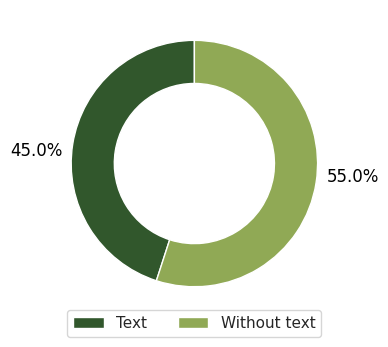

In [188]:
import matplotlib.pyplot as plt
import seaborn as sns

sizes = [n_imgs_w_text, n_imgs_wo_text]
# create data
labels = ['Text', 'Without text']
#colors = ['green', 'orange']
colors = ["#31572c", "#90a955"]

# create plot
fig, ax = plt.subplots(figsize=(4, 4))
wedges, texts, autotexts = ax.pie(sizes, colors=colors, startangle=90, wedgeprops=dict(width=0.35, edgecolor='w'),
                                  autopct='%1.1f%%', textprops=dict(color="black"))

# add title and subtitle
#plt.title('How many images contain text?', fontsize=12)
#plt.suptitle('Proportion of images in the dataset', fontsize=14, fontweight='bold')

# add legend
ax.legend(labels=labels, loc='upper center', bbox_to_anchor=(0.5, .05),
          fancybox=True, ncol=2)

# move the percentage labels outside the chart
for i, text in enumerate(autotexts):
    angle = (wedges[i].theta2 - wedges[i].theta1)/2. + wedges[i].theta1
    x = wedges[i].center[0] + 1.3*wedges[i].r*np.cos(np.pi*angle/180)
    y = wedges[i].center[1] + 0.7*wedges[i].r*np.sin(np.pi*angle/180)
    text.set_position((x,y))

# show plot
plt.show()
fig.figure.savefig(f'{plts_dir}text-freq.png', dpi=300)

### How many images contain text and are also blurred?

In [189]:
def get_flaw(info_img, flaw):
    """
    For a given flaw, checks if it is present in the image
    """
    
    flaws = {'FRM': 0, 'BLR': 1, 'DRK': 2, 'BRT': 3, 
                  'OBS': 4, 'OTH': 5, 'NON': 6, 'ROT': 7}
    idx = flaws[flaw]
    
    return True if info_img["flaws"][idx] == True else False

In [190]:
flaw_typed_imgs = []
flaw = "BLR"

# Return a list with the images that have the given flaw
for img in total_imgs_w_txt:
    info_img = data[img] # dict with img flaws
    if not get_flaw(info_img, "NON"): # if the img is flawed
        answerable = True if info_img["answerable"] == 1.0 else False
        recognizable = True if info_img["recognizable"] == 1.0 else False

        flawed = get_flaw(info_img, flaw) # Specify the desired flaw 

        if answerable and recognizable and flawed:
            flaw_typed_imgs.append(img)


Images containing text and BLR



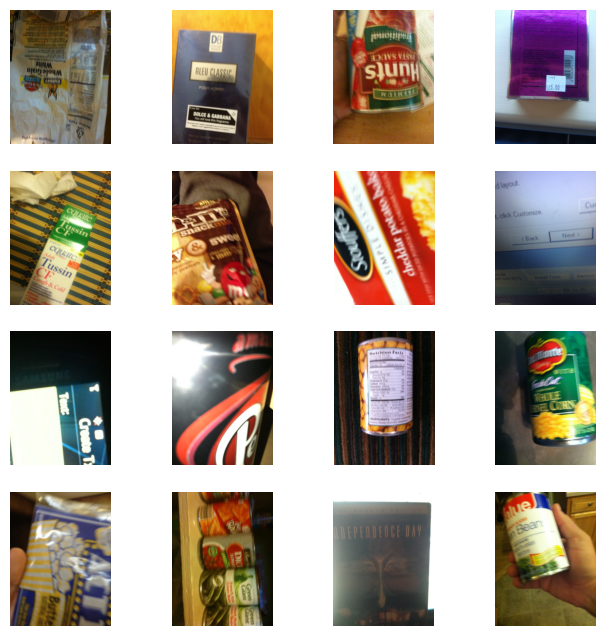

In [191]:
print(f"\nImages containing text and {flaw}\n")
nrow, ncol = 4, 4
_, axs = plt.subplots(nrow, ncol, figsize=(8, 8))
axs = axs.flatten()
random.shuffle(flaw_typed_imgs)
for img, ax in zip(flaw_typed_imgs, axs):
    img = cv2.imread(source + img)
    imgc = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(imgc)
    ax.axis('off')
plt.show()

In [192]:
# Stats
n_flaw_typed_imgs = len(flaw_typed_imgs)

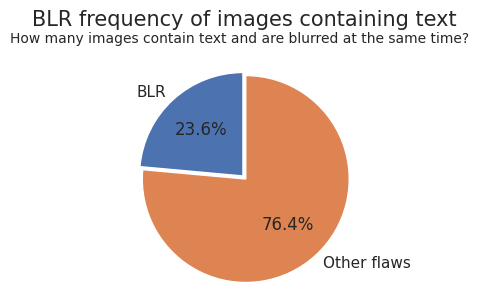

In [193]:
labels = f'{flaw}', 'Other flaws'
other_flaws = len(total_imgs_w_txt) - n_flaw_typed_imgs
sizes = [n_flaw_typed_imgs, other_flaws]
explode = (0.04, 0)  # for highligthing

fig1, ax1 = plt.subplots(figsize=(4, 3))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal') 
fig1.suptitle(f"How many images contain text and are blurred at the same time?",fontsize=10)
ax1.set_title(f"{flaw} frequency of images containing text\n", y=1.02, fontsize=15)
plt.show()

### Which is the frequency of flaws of all images containing text?

In [194]:
# Here we only consider flawed images (skipping NON)
flaws = {'FRM': 0, 'BLR': 0, 'DRK': 0, 'BRT': 0, 
        'OBS': 0, 'OTH': 0, 'ROT': 0}

for i, img in enumerate(total_imgs_w_txt):
    info_img = data[img] # dict with img flaws
    for flaw in flaws.keys():
        if get_flaw(info_img, flaw):
            flaws[flaw] += 1
            
flaws = {flaw : freq for flaw, freq in sorted(flaws.items(),
                                              key=lambda item : item[1],
                                          reverse=True)}


In [195]:
list(flaws.keys())

['FRM', 'BLR', 'ROT', 'BRT', 'DRK', 'OBS', 'OTH']

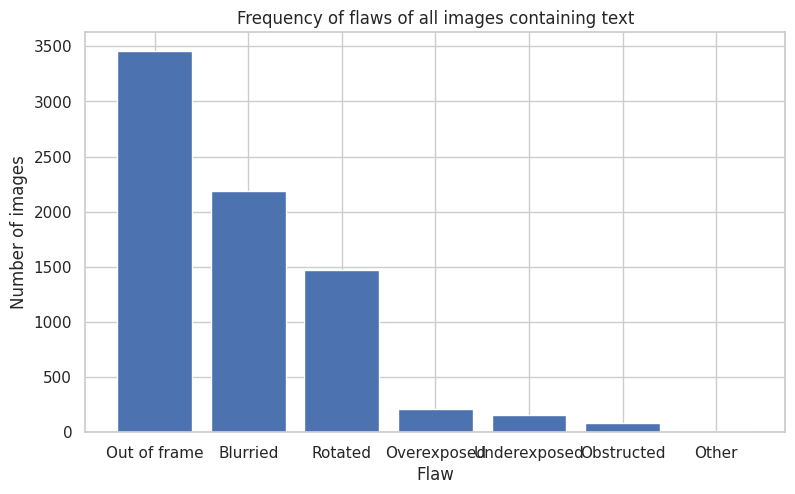

In [196]:
rename_flaws = ['Out of frame', 'Blurried', 'Rotated', 'Overexposed', 'Underexposed', 'Obstructed', 'Other']

fig = plt.figure(figsize=(7,4))
ax = fig.add_axes([0,0,1,1])

x_flaws = list(flaws.keys())
y_freq = list(flaws.values())

ax.bar(rename_flaws,y_freq)
ax.set_xlabel("Flaw")
ax.set_ylabel("Number of images")
ax.set_title("Frequency of flaws of all images containing text")
plt.show()

/tmp/ipykernel_3435/3415651520.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels([f"{val:,.0f}" for val in g.get_yticks()], fontsize=6.4)
/tmp/ipykernel_3435/3415651520.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.yaxis.set_major_formatter(FixedFormatter([f"{val:,.0f}" for val in g.get_yticks()]))


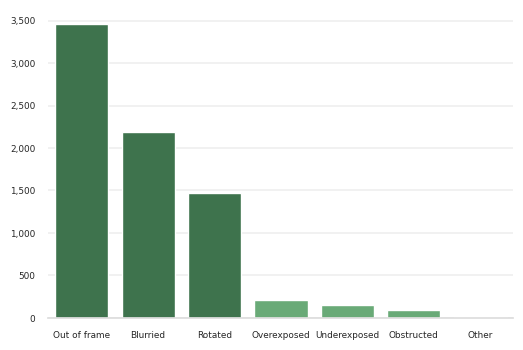

In [197]:
import seaborn as sns
from matplotlib.ticker import FixedLocator, FixedFormatter

fig, ax = plt.subplots(figsize=(6,4))

df = {"flaw-type" : rename_flaws, 'n_images': y_freq}
pal = sns.color_palette("Greens_d", len(df))
array = df['n_images']
rank = [int((max(array)-elem)*len(df)*0.75/(max(array)+1)) for elem in array]
g = sns.barplot(data=df, x="flaw-type", y='n_images', palette=np.array(pal[::-1])[rank], ax=ax)
#plt.suptitle('Frequency of flaws in the dataset', fontsize=12, fontweight='bold')
#plt.title('Which flaws predominate among images that contain text', fontsize=10)
#plt.xlabel('Type of flaw', fontsize=10)
#plt.ylabel('Number of images', fontsize=10)
#g.yaxis.set_major_locator(FixedLocator(g.get_yticks()))

# set xticks and yticks labels
g.set_xticklabels(df['flaw-type'], fontsize=6.4)
g.set_yticklabels([f"{val:,.0f}" for val in g.get_yticks()], fontsize=6.4)
g.yaxis.set_major_formatter(FixedFormatter([f"{val:,.0f}" for val in g.get_yticks()]))
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linewidth=0.15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
vals = ax.get_xticks()

plt.show()

g.figure.savefig(f'{plts_dir}flaws-freq.png', dpi=300)
